# Batch Normalization

Batch normalization will normalize the values for 0 mean and 1std (basically to a gausssian distribution). This will help us in many cases in faster training & better regularization.

Usually we put this in between the Conv/Linear & the Activation Function.

For Conv2D layers, we calculate mean for each channel.

When training, we use the gloabl mean, std of the model instead of the batch's values.

For full details of this, refer [this doc](https://d2l.ai/chapter_convolutional-modern/batch-norm.html).

In [1]:
device = "cuda"

In [2]:
!pip install -q matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [4]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 115 (delta 61), reused 33 (delta 15), pack-reused 0
Receiving objects: 100% (115/115), 4.45 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (61/61), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.4.2 which is incompatible.


In [5]:
transform_pil=transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [6]:
ds_train = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)
ds_valid = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)

In [7]:
ds_train[0][0].shape

torch.Size([1, 28, 28])

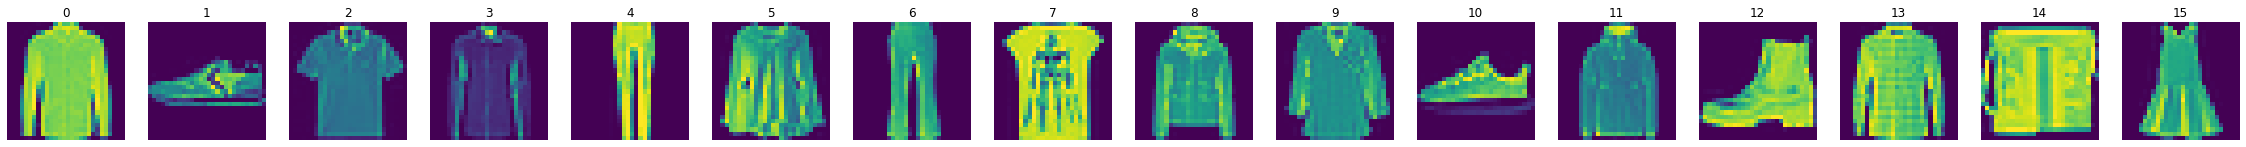

In [8]:
_dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
sample_batch = next(iter(_dl))
test_images = sample_batch[0].to(device)
I.wrap(test_images).show(cols=16)

## LeNet with Batch Normalization

In [11]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [12]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [30]:
class BNLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5),BatchNorm(6, num_dims=4), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(10)
        )
        
    def forward(self, images):
        return self.net(images)
    
_m = BNLeNet().to(device)
_m(test_images).shape

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 10])

## Let's Do the TrainingBNLeNetReLU

In [17]:
# testing initialization
model = BNLeNet().to(device)
model(test_images)
def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        print(layer)
        nn.init.xavier_uniform_(layer.weight)
model.apply(init_weights)
None

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=256, out_features=120, bias=True)
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=10, bias=True)


In [18]:
def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = model(images)
    pred = pred.detach()

    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100

    return accuracy

In [19]:
def train(epochs=1):
    loss_list = []
    valid_loss_list = []
    accuracy_list = []
    valid_accuracy_list = []

    lp = I.live_plot(2)
    i = 0

    for epoch in range(epochs):
        for batch in tqdm(dl_train):
            i += 1;
            images = batch[0].to(device)
            labels = batch[1].to(device)
            batch_size = len(images)

            optimizer.zero_grad()

            yhat = model(images)
            loss = F.cross_entropy(yhat, labels)

            loss.backward()

            with torch.no_grad():   
                optimizer.step()


        with torch.no_grad():
            _dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            train_images, train_lables = sample[0].to(device), sample[1].to(device)

            accuracy_list.append(calc_accuracy(train_images, train_lables).cpu().item())
            train_loss = F.cross_entropy(model(train_images), train_lables)
            loss_list.append(train_loss.item())

            _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            valid_images, valid_lables = sample[0].to(device), sample[1].to(device)

            valid_accuracy_list.append(calc_accuracy(valid_images, valid_lables).cpu().item())
            valid_loss = F.cross_entropy(model(valid_images), valid_lables)
            valid_loss_list.append(valid_loss.item())

        lp.plot(0, loss_list, label="train loss")
        lp.plot(0, valid_loss_list, label="valid loss")
        lp.plot(1, accuracy_list, label="train accuracy")
        lp.plot(1, valid_accuracy_list, label="valid accuracy")
        lp.update()

    lp.close()

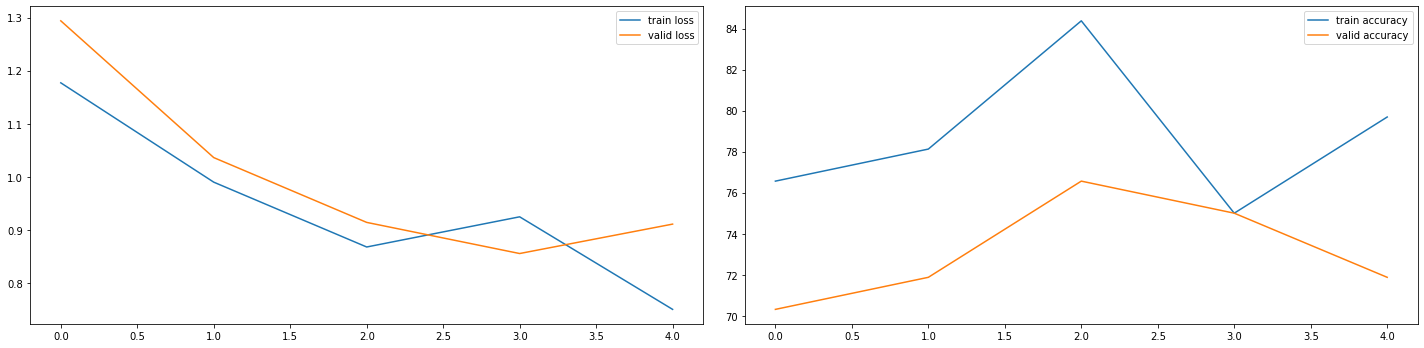

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [27]:
bs = 128
lr = 0.005
wd = 0.0005

def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = BNLeNet().to(device)
model(test_images) #need to initialize parameters for the lazy
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [31]:
def calc_valid_accuracy():
    _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)
    accuracy_list = []
    for batch in tqdm(_dl):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            accuracy_list.append(calc_accuracy(images, labels))

    return torch.tensor(accuracy_list).mean().item()

calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

77.20159912109375

## With ReLU

In [32]:
class BNLeNetReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5),BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), BatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(10)
        )
        
    def forward(self, images):
        return self.net(images)
    
_m = BNLeNet().to(device)
_m(test_images).shape

torch.Size([16, 10])

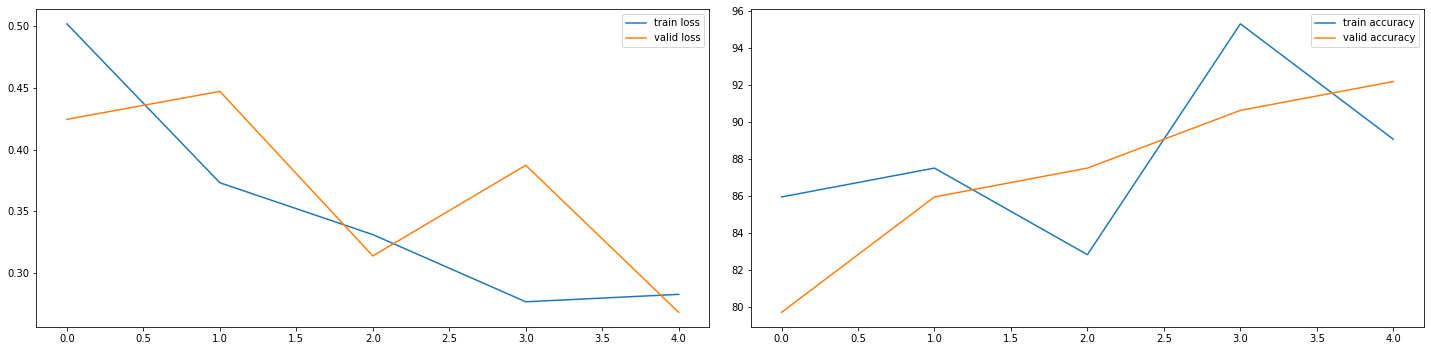

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [34]:
bs = 128
lr = 0.01
wd = 0.0005

def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = BNLeNetReLU().to(device)
model(test_images) #need to initialize parameters for the lazy
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [35]:
calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

86.92697143554688

## Without Weights Initialization

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


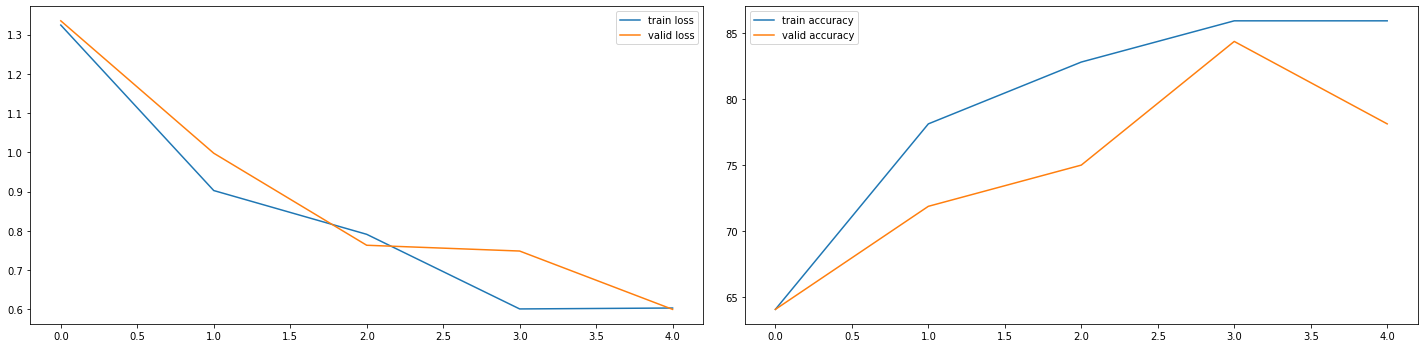

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [38]:
bs = 128
lr = 0.01
wd = 0.0005

def init_weights(layer):
    if type(layer) == nn.modules.conv.Conv2d or type(layer) == nn.modules.linear.Linear:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = BNLeNet().to(device)
model(test_images) #need to initialize parameters for the lazy
# model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [39]:
calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

79.89961242675781

## Conclusion

It's hard to say whether batch normalization helps or not here.
But we don't have to do weights initialization.